# Imports

In [1]:
# All imports

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import glob

import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'1.14.0'

# Data Loading

In [47]:
# unzipping files

import zipfile
with zipfile.ZipFile('./trafficsigns_shapedata.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [2]:
# Loading image path and labels
image_list = []
for filepath in glob.glob('./trafficsigns_shapedata/*/*.png', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
    image_list.append((filepath, label))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

# Inspecting Data

In [70]:
data.head()

(3650, 2)


In [71]:
print(data.shape)
data.label.unique()

(3650, 2)


array(['square', 'diamond', 'hex', 'triangle', 'round'], dtype=object)

Data contains two columns, having location of image and its corresponding label. We have a total of 5 label classes from which we need to classify. our total dataset contains 3650 images

In [22]:
data.groupby(['label']).count()

,image_path
label,
diamond,282
hex,43
round,1711
square,688
triangle,926


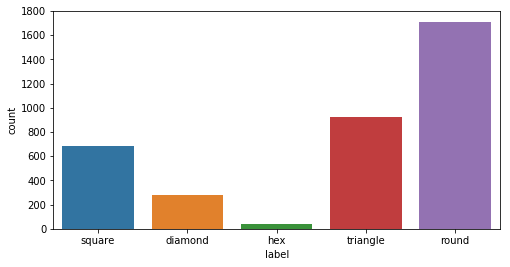

In [21]:
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=data);# unbalanced classes

We can see from above visualisation that classes are unbalanced

# Display images

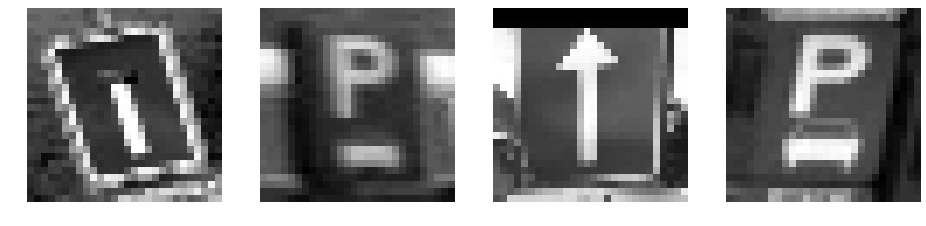

In [8]:
# displaying random images

r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

# Label mapping

In [52]:
#label mapping
d = {'square':0, 'diamond':1, 'hex':2, 'triangle':3, 'round':4}
data['labels_num'] = data['label'].map(d, na_action='ignore')

# Train Test split

In [9]:
#generating training, testing and validation sets

temptrainData, testData = train_test_split(data ,test_size=0.20, random_state=42)
trainData, validateData = train_test_split(temptrainData ,test_size=0.25, random_state=42)

In [10]:
print(trainData.shape)
print(testData.shape)
print(validateData.shape)

(2190, 2)
(730, 2)
(730, 2)


In [11]:
N_train_images = trainData.shape[0]
N_val_images = validateData.shape[0]
N_test_images = testData.shape[0]

# Some other utility functions

In [12]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    
    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
    return np.mean(loss_hold), np.mean(acc_hold)

In [13]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

In [14]:
def train_model(model_, num_epoch=50, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

Image data generators to augment the image and load into batches to increase computational efficiency

In [73]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validateData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2920 validated image filenames belonging to 5 classes.
Found 730 validated image filenames belonging to 5 classes.


# Creating model (CNN)

- starting with the most basic model

In [77]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, (3, 3), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 27045     
_________________________________________________________________
activation_8 (Activation)    (None, 5)                 0         
Total params: 27,941
Trainable params: 27,941
Non-trainable params: 0
__________________________________________________

In [78]:
res = train_model(model_cnn, num_epoch=10, verbose=True)

Training epoch 0: Loss = 1.212717056274414, Accuracy = 0.5196167826652527
Validation epoch 0: Loss = 1.037111036155535, Accuracy = 0.6092391014099121
Training epoch 1: Loss = 1.0789681673049927, Accuracy = 0.5941886901855469
Validation epoch 1: Loss = 0.7446144838695941, Accuracy = 0.750271737575531
Training epoch 2: Loss = 0.9375367760658264, Accuracy = 0.6589697003364563
Validation epoch 2: Loss = 0.6190682805102804, Accuracy = 0.8198369741439819
Training epoch 3: Loss = 0.884446382522583, Accuracy = 0.6756036281585693
Validation epoch 3: Loss = 0.5964920737821123, Accuracy = 0.7864130139350891
Training epoch 4: Loss = 0.7943530082702637, Accuracy = 0.7049760818481445
Validation epoch 4: Loss = 0.46756702272788336, Accuracy = 0.8475543260574341
Training epoch 5: Loss = 0.7790563702583313, Accuracy = 0.7262423038482666
Validation epoch 5: Loss = 0.44470021906106366, Accuracy = 0.8611412644386292
Training epoch 6: Loss = 0.7202893495559692, Accuracy = 0.7509474754333496
Validation epoc

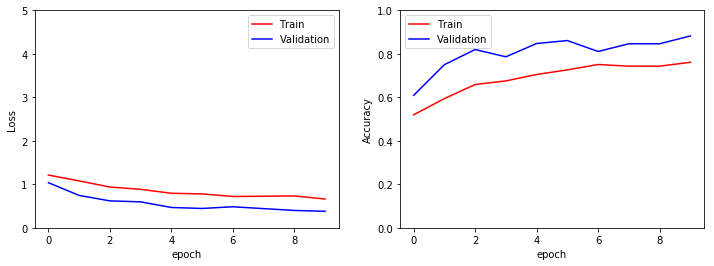

In [79]:
plot_results(res)

Increasing the complexity of model by adding more layers

In [85]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3)))
model_cnn.add(Activation('relu'))
#model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
activation_19 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_20 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_21 (Activation)   (None, 9, 9, 64)         

In [ ]:
res = train_model(model_cnn, num_epoch=100, verbose=True)

Training epoch 0: Loss = 1.2867169380187988, Accuracy = 0.45894160866737366
Validation epoch 0: Loss = 1.2001476987548496, Accuracy = 0.530706524848938
Training epoch 1: Loss = 1.114516019821167, Accuracy = 0.5646055340766907
Validation epoch 1: Loss = 0.7841631459153217, Accuracy = 0.7451087236404419
Training epoch 2: Loss = 0.9053158164024353, Accuracy = 0.6599873900413513
Validation epoch 2: Loss = 0.570970706641674, Accuracy = 0.780978262424469
Training epoch 3: Loss = 0.7603802680969238, Accuracy = 0.7244174480438232
Validation epoch 3: Loss = 0.37374118909887644, Accuracy = 0.8769022226333618
Training epoch 4: Loss = 0.6193707585334778, Accuracy = 0.7861103415489197
Validation epoch 4: Loss = 0.35293923350779904, Accuracy = 0.886956512928009
Training epoch 5: Loss = 0.5573495030403137, Accuracy = 0.8073413968086243
Validation epoch 5: Loss = 0.30772700711436896, Accuracy = 0.9021739363670349
Training epoch 6: Loss = 0.4601033329963684, Accuracy = 0.842574417591095
Validation epoc

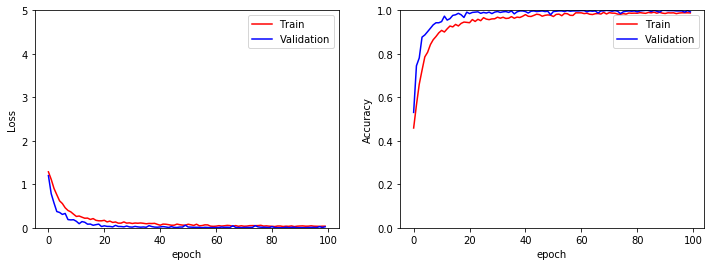

In [87]:
plot_results(res)

Incorporating regularisation and dropout 

In [89]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
#model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
activation_29 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_30 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_31 (Activation)   (None, 9, 9, 64)         

In [91]:
res = train_model(model_cnn, num_epoch=100, verbose=True)

Training epoch 0: Loss = 0.5237309336662292, Accuracy = 0.8284320831298828
Validation epoch 0: Loss = 0.20358073557524578, Accuracy = 0.9440217018127441
Training epoch 1: Loss = 0.4869726598262787, Accuracy = 0.8446799516677856
Validation epoch 1: Loss = 0.24049660935997963, Accuracy = 0.945652186870575
Training epoch 2: Loss = 0.47196364402770996, Accuracy = 0.8600154519081116
Validation epoch 2: Loss = 0.21128910164470258, Accuracy = 0.9285326600074768
Training epoch 3: Loss = 0.4553785026073456, Accuracy = 0.8630334138870239
Validation epoch 3: Loss = 0.16971817564057268, Accuracy = 0.9625000357627869
Training epoch 4: Loss = 0.3928486108779907, Accuracy = 0.8817378282546997
Validation epoch 4: Loss = 0.22404348542508873, Accuracy = 0.939945638179779
Training epoch 5: Loss = 0.3878307342529297, Accuracy = 0.8883702754974365
Validation epoch 5: Loss = 0.14948087695824064, Accuracy = 0.9611413478851318
Training epoch 6: Loss = 0.40304216742515564, Accuracy = 0.8901950716972351
Validat

In [30]:
res = model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=10)

Epoch 1/10
137/137 [==============================] - 3s 21ms/step - loss: 0.1555 - categorical_accuracy: 0.9703 - val_loss: 0.0890 - val_categorical_accuracy: 0.9932
Epoch 2/10
137/137 [==============================] - 3s 22ms/step - loss: 0.1778 - categorical_accuracy: 0.9603 - val_loss: 0.0906 - val_categorical_accuracy: 0.9932
Epoch 3/10
137/137 [==============================] - 3s 21ms/step - loss: 0.1722 - categorical_accuracy: 0.9658 - val_loss: 0.0820 - val_categorical_accuracy: 0.9932
Epoch 4/10
137/137 [==============================] - 3s 21ms/step - loss: 0.1563 - categorical_accuracy: 0.9703 - val_loss: 0.0862 - val_categorical_accuracy: 0.9945
Epoch 5/10
137/137 [==============================] - 3s 21ms/step - loss: 0.1429 - categorical_accuracy: 0.9703 - val_loss: 0.0735 - val_categorical_accuracy: 0.9945
Epoch 6/10
137/137 [==============================] - 3s 20ms/step - loss: 0.1538 - categorical_accuracy: 0.9703 - val_loss: 0.0934 - val_categorical_accuracy: 0.983

AttributeError: 'History' object has no attribute 'plot'

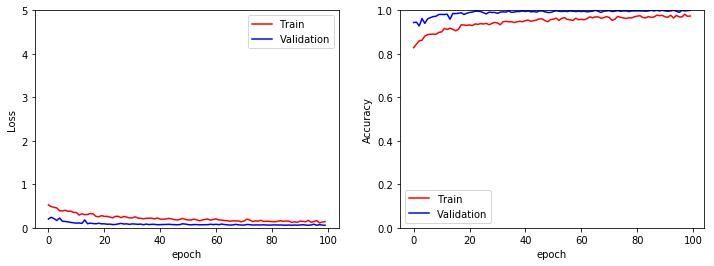

In [94]:
plot_results(res)

In [68]:
#Prediction below

In [92]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = test_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
shuffle = False)


Found 730 validated image filenames belonging to 5 classes.


[[9.9998343e-01 1.1926794e-17 1.6574835e-05 2.4849178e-21 3.1172080e-17]]
[[1. 0. 0. 0. 0.]]
[[5.9575545e-23 5.5325107e-19 1.0000000e+00 3.7840179e-25 1.4652970e-21]]
[[0. 0. 1. 0. 0.]]
[[1.0000000e+00 3.8105254e-18 7.9255363e-10 2.1220965e-20 1.7851408e-17]]
[[1. 0. 0. 0. 0.]]
[[1.2734047e-25 6.3993366e-21 1.0000000e+00 3.1821228e-27 1.8868529e-23]]
[[0. 0. 1. 0. 0.]]
[[6.4902697e-15 3.1235596e-15 4.5514325e-11 6.8160179e-11 1.0000000e+00]]
[[0. 0. 0. 0. 1.]]


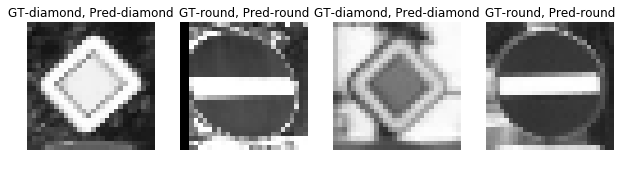

In [97]:
labels = (test_generator.class_indices)

d_inv = {v: k for k, v in labels.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cnn.predict(x, verbose=0)
        print(y_hat)
        print(y)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,6,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [33]:
# using random forest

In [54]:
#imports
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [35]:
data.head()

,image_path,label
0,./trafficsigns_shapedata/square/00290_00001.png,square
1,./trafficsigns_shapedata/square/01577_00000.png,square
2,./trafficsigns_shapedata/square/01366_00000.png,square
3,./trafficsigns_shapedata/square/00482_00000.png,square
4,./trafficsigns_shapedata/square/01731_00000.png,square


In [36]:
trainData, testData = train_test_split(data ,test_size=0.20, random_state=42)

In [37]:
trainData.shape

(2920, 2)

In [49]:
X_train = trainData.iloc[:,0:1]
y_train = trainData.label.astype("str")

In [50]:
x_train, x_test, y_train_v, y_test_v = train_test_split(X_train,y_train, test_size = 0.3, random_state = 2)

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')


Found 2920 validated image filenames belonging to 5 classes.


In [55]:
rf = RandomForestClassifier()

In [56]:
rf.fit(x_train,y_train_v)

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: './trafficsigns_shapedata/square/00850_00001.png'